<a href="https://colab.research.google.com/github/sajjkavinda/rsna-classification/blob/main/bone_fractures_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/rsna_subset_png.zip" -d "/content/rsna_subset"


Streaming output truncated to the last 5000 lines.
  inflating: /content/rsna_subset/kaggle/working/rsna_subset/1.2.826.0.1.3680043.32480/397.dcm  
  inflating: /content/rsna_subset/kaggle/working/rsna_subset/1.2.826.0.1.3680043.32480/162.dcm  
  inflating: /content/rsna_subset/kaggle/working/rsna_subset/1.2.826.0.1.3680043.32480/326.dcm  
  inflating: /content/rsna_subset/kaggle/working/rsna_subset/1.2.826.0.1.3680043.32480/280.dcm  
  inflating: /content/rsna_subset/kaggle/working/rsna_subset/1.2.826.0.1.3680043.32480/369.dcm  
  inflating: /content/rsna_subset/kaggle/working/rsna_subset/1.2.826.0.1.3680043.32480/225.dcm  
  inflating: /content/rsna_subset/kaggle/working/rsna_subset/1.2.826.0.1.3680043.32480/244.dcm  
  inflating: /content/rsna_subset/kaggle/working/rsna_subset/1.2.826.0.1.3680043.32480/299.dcm  
  inflating: /content/rsna_subset/kaggle/working/rsna_subset/1.2.826.0.1.3680043.32480/6.dcm  
  inflating: /content/rsna_subset/kaggle/working/rsna_subset/1.2.826.0.1.36800

In [3]:
import os
os.listdir("/content/rsna_subset/kaggle/working/rsna_subset")[:5]

['1.2.826.0.1.3680043.6741',
 '1.2.826.0.1.3680043.510',
 '1.2.826.0.1.3680043.6281',
 '1.2.826.0.1.3680043.28233',
 '1.2.826.0.1.3680043.17210']

In [4]:
!pip uninstall -y gdcm python-gdcm pydicom pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg
!pip install pydicom pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg
!pip install opencv-python matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 84.9 MB/s eta 0:00:00


In [5]:
import os
import pydicom
import cv2
from tqdm import tqdm

input_dir = "/content/rsna_subset/kaggle/working/rsna_subset"
output_dir = "/content/rsna_png_images"
os.makedirs(output_dir, exist_ok=True)

for patient in tqdm(os.listdir(input_dir)):
    patient_path = os.path.join(input_dir, patient)
    if not os.path.isdir(patient_path):
        continue
    patient_output = os.path.join(output_dir, patient)
    os.makedirs(patient_output, exist_ok=True)

    for file in os.listdir(patient_path):
        if file.endswith(".dcm"):
            dcm_path = os.path.join(patient_path, file)
            png_path = os.path.join(patient_output, file.replace(".dcm", ".png"))

            try:
                dcm = pydicom.dcmread(dcm_path)
                img = dcm.pixel_array
                img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
                cv2.imwrite(png_path, img)
            except Exception as e:
                print(f"Error converting {dcm_path}: {e}")


100%|██████████| 20/20 [01:32<00:00,  4.61s/it]


Available fractured: 10, normal: 10
Fractured Study UID: 1.2.826.0.1.3680043.19258
Normal Study UID: 1.2.826.0.1.3680043.32480


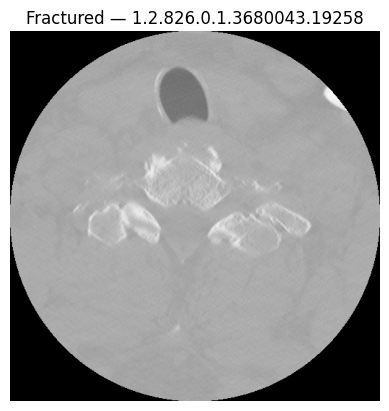

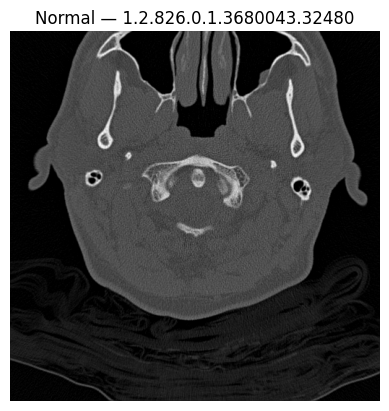

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Load CSV
labels = pd.read_csv("/content/train.csv")

# Get available folders (already converted)
available_uids = set(os.listdir("/content/rsna_png_images"))

# Filter labels for those that exist in the converted folder
labels_existing = labels[labels["StudyInstanceUID"].isin(available_uids)]

# Separate fractured and normal
fractured_cases = labels_existing[labels_existing["patient_overall"] == 1]
normal_cases = labels_existing[labels_existing["patient_overall"] == 0]

print(f"Available fractured: {len(fractured_cases)}, normal: {len(normal_cases)}")

# Pick one of each
fractured_uid = fractured_cases["StudyInstanceUID"].iloc[0]
normal_uid = normal_cases["StudyInstanceUID"].iloc[0]

print("Fractured Study UID:", fractured_uid)
print("Normal Study UID:", normal_uid)

# Display Images
def show_example(study_uid, label):
    study_path = os.path.join("/content/rsna_png_images", study_uid)
    files = sorted([f for f in os.listdir(study_path) if f.endswith(".png")])

    if not files:
        print(f"No images found for {study_uid}")
        return

    img_path = os.path.join(study_path, files[len(files)//2])  # middle slice
    img = Image.open(img_path)

    plt.imshow(img, cmap="gray")
    plt.title(f"{label} — {study_uid}")
    plt.axis("off")
    plt.show()

show_example(fractured_uid, "Fractured")
show_example(normal_uid, "Normal")


In [ ]:
import pandas as pd

base_dir = "/content/"

# Load labels again if needed
labels = pd.read_csv(base_dir + "train.csv")

# Keep only the subset
subset_ids = os.listdir("/content/rsna_png_images")
subset_labels = labels[labels["StudyInstanceUID"].isin(subset_ids)][["StudyInstanceUID", "patient_overall"]]

print(subset_labels.head())

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [16]:
class SpineDataset(Dataset):
    def __init__(self, df, base_dir, transform=None):
        self.df = df
        self.base_dir = base_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        study_uid = row["StudyInstanceUID"]
        label = row["patient_overall"]

        folder = os.path.join(self.base_dir, study_uid)
        files = [f for f in os.listdir(folder) if f.endswith(".png")]
        img_path = os.path.join(folder, files[len(files)//2])  # middle slice

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)


In [17]:
base_dir = "/content/rsna_png_images"
train_df = labels_existing.sample(frac=0.8, random_state=42)
val_df = labels_existing.drop(train_df.index)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = SpineDataset(train_df, base_dir, transform)
val_dataset = SpineDataset(val_df, base_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 111MB/s]


In [19]:
EPOCHS = 3

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Train loss: {total_loss/len(train_loader):.4f}")


Epoch 1/3: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Train loss: 0.8034


Epoch 2/3: 100%|██████████| 2/2 [00:00<00:00,  7.37it/s]


Train loss: 0.1519


Epoch 3/3: 100%|██████████| 2/2 [00:00<00:00,  9.08it/s]

Train loss: 0.0426


In [20]:
model.eval()
predictions, truths = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, 1).cpu().numpy()
        predictions.extend(preds)
        truths.extend(labels.numpy())

acc = np.mean(np.array(predictions) == np.array(truths))
print(f"Validation Accuracy: {acc:.2%}")


Validation Accuracy: 50.00%


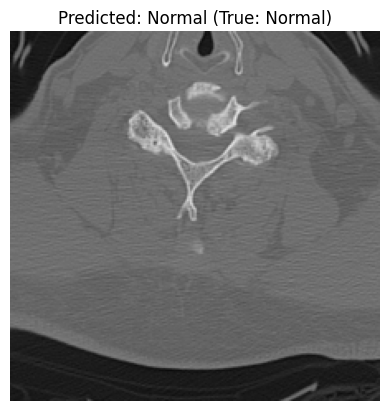

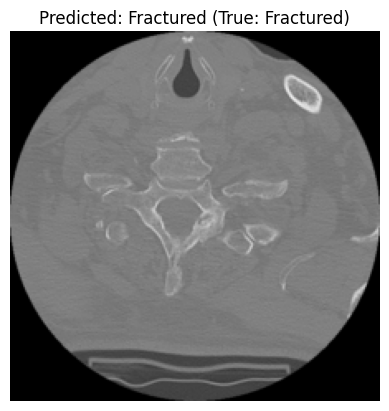

In [22]:
def denormalize(img_tensor):
    """Undo ImageNet normalization to make the image viewable."""
    import torch
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    img = torch.clamp(img, 0, 1)
    return img

def show_predictions(dataset, model, device, label_names=["Normal", "Fractured"]):
    model.eval()
    shown = {"pos": False, "neg": False}

    for i in range(len(dataset)):
        img, label = dataset[i]
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device))
            pred_label = torch.argmax(pred, 1).item()

        # Pick one predicted positive and one predicted negative
        if (pred_label == 1 and not shown["pos"]) or (pred_label == 0 and not shown["neg"]):
            img_vis = denormalize(img)
            plt.imshow(np.transpose(img_vis.numpy(), (1, 2, 0)))
            plt.title(f"Predicted: {label_names[pred_label]} (True: {label_names[label]})")
            plt.axis("off")
            plt.show()

            if pred_label == 1:
                shown["pos"] = True
            else:
                shown["neg"] = True

        if all(shown.values()):
            break

show_predictions(val_dataset, model, device)
